## Workflows and Agents ##

**Workflows** are systems where LLMs and tools are orchestrated through predefined code paths. 

**Agents**, on the other hand, are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks.

![Agent Workflow](agent_workflow.png)

In [1]:
%pip install -qU langchain_core langchain-google-genai langgraph
%pip install -qU graphviz
%pip install -qU nest_asyncio


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

## Building Blocks: The Augmented LLM ##

LLM have augmentations that support building workflows and agents. These include [structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/) and [tool calling](https://python.langchain.com/docs/concepts/tool_calling/), as shown in this image from the Anthropic blog on `Building Effective Agents`:

![The Augmented LLM](augmented_llm.png)

In [2]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(None, description="Why this query is relevant to the user's request.")

# Augumet the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")


In [3]:
output

SearchQuery(search_query='Calcium CT score and high cholesterol', justification='To find the relationship between Calcium CT score and high cholesterol')

In [4]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

msg = llm_with_tools.invoke("What is 2 times 3?")

msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2.0, 'b': 3.0},
  'id': '282f99cf-6d6f-4726-a15b-d906d1b579d7',
  'type': 'tool_call'}]

## Prompt chaining ##

Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks (see "gate” in the diagram below) on any intermediate steps to ensure that the process is still on track.

`When to use this workflow`: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

![Prompt chaining](prompt_chain.png)

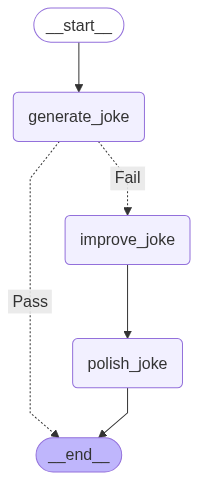

In [5]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {'joke': msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}    
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [6]:
# Invoke
state = chain.invoke({"topic": "cats"})

print(f"Initial joke: {state['joke']}")
print("\n--- --- ---\n")
if "improved_joke" in state:
    print(f"Improved joke: {state['improved_joke']}")
    print("\n--- --- ---\n")
    print(f"Final joke: {state['final_joke']}")
else:
    print("Joke failed quality gate - no punchline detected!")


Initial joke: Why did the cat join the Red Cross?

Because it heard they needed someone to give first *aid*!

--- --- ---

Improved joke: Okay, that's a good start! Here are a few more options, playing with different aspects of the joke and adding some wordplay:

**Option 1 (Focus on the Cat/Red Cross Connection):**

Why did the cat join the Red Cross?

Because it wanted to be a paws-itive influence and help people get back on their feet... or should I say, *paws*!

**Option 2 (Focus on the "Aid" Wordplay):**

Why did the cat join the Red Cross?

Because it wanted to lend a helping paw... and maybe get some *purr*-diem for all its *aid* work!

**Option 3 (Slightly Darker, but with a Pun):**

Why did the cat join the Red Cross?

Because it heard they were running low on *cat*astrophe relief supplies... and it felt a *furry* strong urge to help.

**Option 4 (Short and Sweet):**

Why did the cat join the Red Cross?

To offer a *claw*-ver solution to every emergency!

**Why these work:**



## Parallelization ##

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, **parallelization**, manifests in two key variations: 

* **Sectioning**: Breaking a task into independent subtasks run in parallel. 
* **Voting**: Running the same task multiple times to get diverse outputs.

`When to use this workflow`: **Parallelization** is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

![parallelization](parallelization.png)

In [7]:

# Graph State
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def call_llm_2(state: State):
    """Second LLM call to generate initial story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}

def call_llm_3(state: State):
    """Third LLM call to generate initial poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


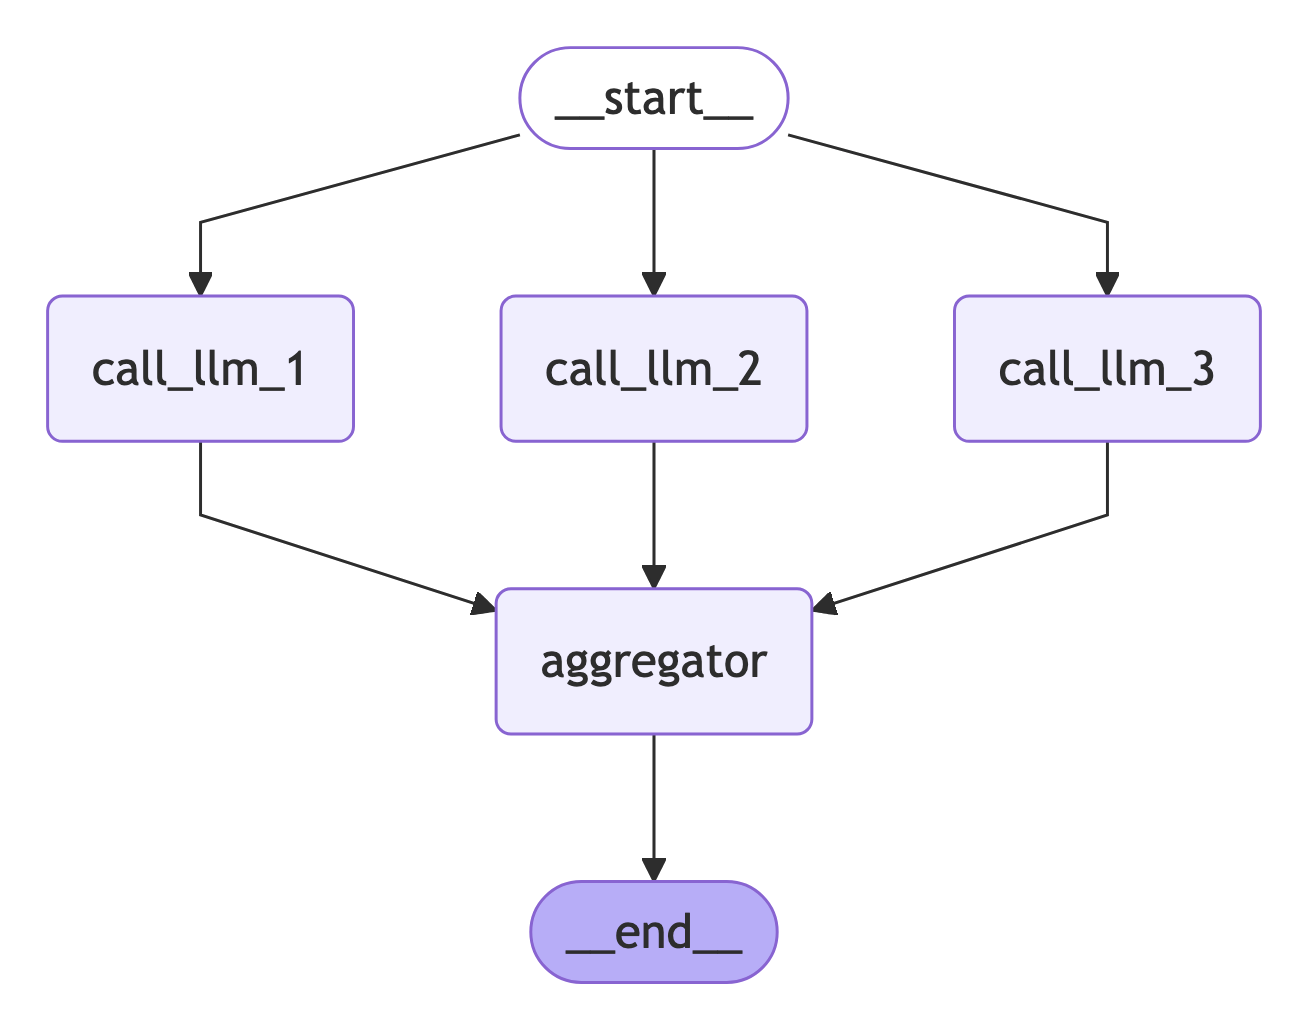

In [8]:
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)

parallel_workflow = parallel_builder.compile()

# Show workflow
import nest_asyncio
nest_asyncio.apply()

display(Image(parallel_workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))


In [9]:
# Invoke
state = parallel_workflow.invoke({"topic": "cats"})

print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
The moon hung fat and luminous over the rooftops of Lisbon, painting the terracotta tiles in silver. Below, in the labyrinthine alleyways, a different kind of magic stirred. It was the hour of the cats.

Luna, a sleek black cat with emerald eyes, was the queen of her corner of the Alfama district. Tonight, she was on patrol. She moved with a silent grace, a shadow among shadows, her whiskers twitching, gathering the scent of the night.

She passed old Manuela's bakery, the lingering aroma of day-old *pastel de nata* still clinging to the air. She flicked her tail in acknowledgment – Manuela was a good human, always leaving a saucer of milk out back.

Then, she heard it. A high-pitched, desperate mewling coming from the abandoned courtyard behind the cathedral. Luna tensed. Kittens.

She slipped through the crumbling archway, her eyes adjusting to the deeper darkness. There, huddled beneath a pile of discarded newspapers, were three tin

## Routing ##

Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

`When to use this workflow`: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

![Routing](routing.png)

In [10]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

# State
class State(TypedDict):
    input: str
    decision: str
    output: str

# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"
    

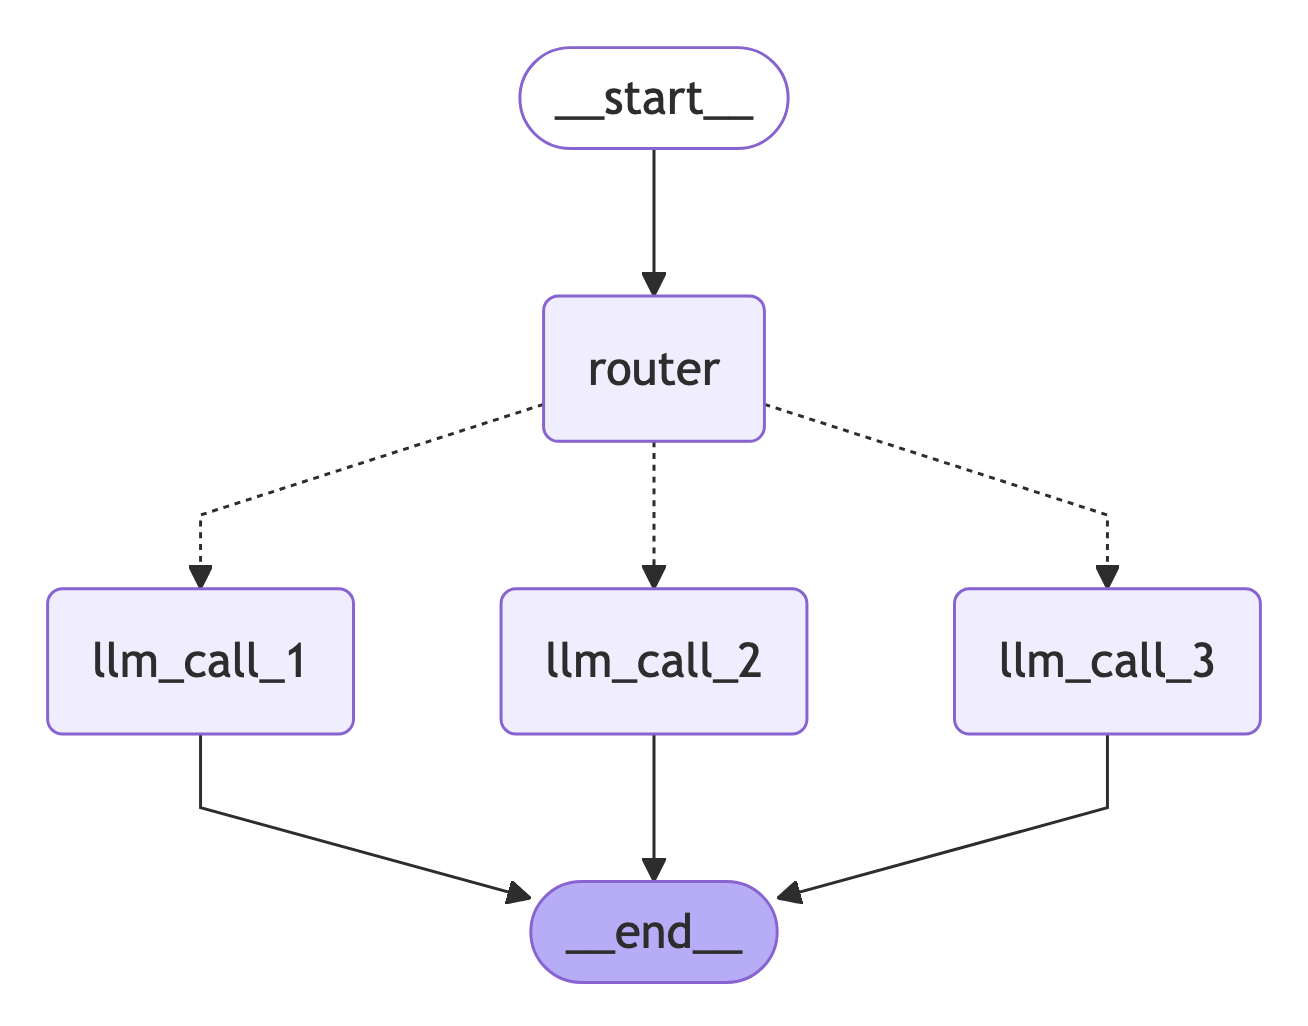

In [11]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("router", llm_call_router)
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)

# Add edges to connect nodes
router_builder.set_entry_point("router")

# Add conditional edges from the router to the appropriate LLM call node
router_builder.add_conditional_edges(
    "router",
    route_decision,
    {
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)

# Add edges from each LLM call node to the end
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# 워크플로우 컴파일
router_graph = router_builder.compile()

import nest_asyncio
nest_asyncio.apply()

display(Image(router_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))
# display(Image(router_graph.get_graph().draw_mermaid_png()))


In [12]:
# Invoke
state = router_graph.invoke({"input": "Write me a joke about cats"})

In [13]:
print(state["output"])

Why did the cat join the Red Cross?

Because it heard they needed someone to give first aid!


## Orchestrator-Worker ##

오케스트레이터-워커 워크플로에서 중앙 LLM은 작업을 동적으로 분할하고, 이를 워커 LLM에 위임하고, 결과를 종합합니다.

```이 워크플로를 사용하는 경우```: 이 워크플로는 필요한 하위 작업을 예측할 수 없는 복잡한 작업에 적합합니다(예: 코딩 시 변경해야 할 파일 수와 각 파일의 변경 내용은 작업에 따라 달라질 수 있음). 지형적으로는 유사하지만, 병렬화와의 주요 차이점은 유연성입니다. 하위 작업은 미리 정의되지 않고 오케스트레이터가 특정 입력을 기반으로 결정합니다.

![Worker](worker.png)

In [14]:
from typing import Annotated, List
import operator

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report."
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

### LangGraph에서 워커 생성하기 ###

오케스트레이터-워커 워크플로는 일반적이기 때문에 LangGraph는 이를 지원하는 Send API를 제공합니다. 이 API를 사용하면 동적으로 워커 노드를 생성하고 각 노드에 특정 입력을 전송할 수 있습니다. 각 워커는 고유한 상태를 가지며, 모든 워커 출력은 오케스트레이터 그래프에서 액세스할 수 있는 공유 상태 키에 기록됩니다. 이를 통해 오케스트레이터는 모든 워커 출력에 접근하고 이를 합성하여 최종 출력을 생성할 수 있습니다. 아래에서 볼 수 있듯이, 섹션 목록을 반복하며 각 섹션을 워커 노드로 전송합니다. 자세한 내용은 [여기](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/)와 [여기](https://langchain-ai.github.io/langgraph/concepts/low_level/#send)에서 확인하세요.



In [19]:
from langgraph.constants import Send

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
        # All workers write to this key in parallel
    ]
    final_report: str   # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report"),
            HumanMessage(content=f"Here is the report topic: {state['topic']}")
        ]
    )
    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."),
            HumanMessage(content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}")
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]



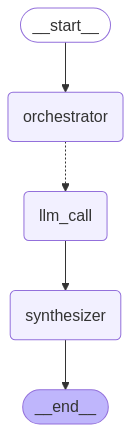

In [20]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [ ]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})


'## Introduction\n\nScaling laws in large language models (LLMs) describe the predictable relationship between model performance, model size (number of parameters), dataset size, and the amount of compute used for training. These laws demonstrate that, generally, increasing any of these factors leads to improved performance, often in a power-law fashion.\n\nThe importance of understanding scaling laws lies in their ability to:\n\n*   **Predict future performance:** By extrapolating from smaller models, we can estimate the performance of larger models without actually training them. This allows for informed decisions about resource allocation.\n*   **Optimize training:** Scaling laws can guide the selection of appropriate model sizes, dataset sizes, and compute budgets to achieve desired performance levels.\n*   **Identify bottlenecks:** Deviations from predicted scaling behavior can reveal inefficiencies in training pipelines or limitations in model architectures.\n*   **Inform hardwar

In [23]:

from IPython.display import Markdown
Markdown(state["final_report"])

## Introduction

Scaling laws in large language models (LLMs) describe the predictable relationship between model performance, model size (number of parameters), dataset size, and the amount of compute used for training. These laws demonstrate that, generally, increasing any of these factors leads to improved performance, often in a power-law fashion.

The importance of understanding scaling laws lies in their ability to:

*   **Predict future performance:** By extrapolating from smaller models, we can estimate the performance of larger models without actually training them. This allows for informed decisions about resource allocation.
*   **Optimize training:** Scaling laws can guide the selection of appropriate model sizes, dataset sizes, and compute budgets to achieve desired performance levels.
*   **Identify bottlenecks:** Deviations from predicted scaling behavior can reveal inefficiencies in training pipelines or limitations in model architectures.
*   **Inform hardware development:** Understanding the compute requirements for training future LLMs can drive innovation in hardware design and optimization.
*   **Understand emergent abilities:** Scaling laws provide a framework for studying how new capabilities emerge as models grow larger.

This report will delve into the specifics of these scaling laws, examining the empirical evidence supporting them, the theoretical underpinnings attempting to explain them, and the practical implications for training and deploying LLMs. We will discuss the limitations of current scaling laws, explore recent research aimed at refining them, and address the challenges associated with scaling beyond current limits. The scope includes a review of relevant literature, analysis of publicly available data, and a discussion of future research directions in this rapidly evolving field.

---

### Scaling Laws Explained

Scaling laws in large language models (LLMs) describe the predictable relationship between model size (number of parameters, *N*), the amount of training data used (*D*), the amount of compute used during training (*C*), and the resulting performance of the model (typically measured by loss, *L*). These relationships are often expressed as power laws:

*L* ∝ *N*<sup>-*α*</sup>
*L* ∝ *D*<sup>-*β*</sup>
*L* ∝ *C*<sup>-*γ*</sup>

Where *α*, *β*, and *γ* are empirically derived exponents, typically positive values less than 1.  These equations indicate that as you increase model size, dataset size, or compute, the loss decreases (performance improves) according to a power law.  This means that doubling the model size, for example, does *not* halve the loss; it decreases the loss by a factor of 2<sup>-*α*</sup>.

**Key Components and Implications:**

*   **Model Size (N):** The number of trainable parameters in the LLM.  Larger models generally have a greater capacity to learn complex patterns and relationships in the data.  However, increasing model size without sufficient data or compute can lead to diminishing returns or overfitting.

*   **Dataset Size (D):** The amount of training data used to train the LLM. A larger and more diverse dataset allows the model to generalize better to unseen data and avoid memorization.  However, the quality and relevance of the data are crucial.  Simply increasing the quantity of low-quality data may not improve performance.

*   **Compute (C):** The amount of computational resources (e.g., FLOPs - Floating Point Operations) used during training.  More compute allows for more training iterations and a more thorough exploration of the model's parameter space.  Insufficient compute can prevent the model from converging to its optimal performance, even with a large model and dataset.

*   **Loss (L):** A measure of how well the model predicts the next token in a sequence. Lower loss indicates better performance.  Loss is typically evaluated on a held-out validation dataset to assess generalization ability.

**Joint Scaling Laws:**

While the individual scaling laws are informative, it is important to consider them jointly.  The overall loss can be approximated by a combination of these factors:

*L* ≈ *A* *N*<sup>-*α*</sup> + *B* *D*<sup>-*β*</sup> + *C*  (simplified example)

Where *A*, *B*, and *C* are constants.  This highlights the trade-offs between model size, dataset size, and compute.  For example, it may be more cost-effective to increase the dataset size rather than drastically increasing the model size, depending on the values of *α* and *β*.

**Optimality and Chinchilla Optimal Models:**

Recent research has focused on determining the optimal balance between model size and dataset size for a given compute budget. The "Chinchilla" paper introduced the concept of *compute-optimal* models. This means that for a given compute budget, there exists a specific model size and dataset size that will achieve the best possible performance.  Chinchilla demonstrated that previous models like GPT-3 were significantly undertrained, meaning they were too large for the amount of data they were trained on. By training a smaller model on more data, they achieved significantly better performance.

**Limitations and Future Directions:**

While scaling laws provide a valuable framework for understanding LLM performance, they have limitations:

*   **Data Quality:** Scaling laws often assume a fixed data distribution and quality.  In reality, the quality and relevance of the training data can significantly impact performance.
*   **Architecture:** Scaling laws are typically derived for specific model architectures. Different architectures may exhibit different scaling behavior.
*   **Emergent Abilities:** Some emergent abilities, such as in-context learning, may not be fully captured by simple loss metrics.
*   **Saturation:** There is evidence to suggest that scaling laws may eventually saturate, meaning that increasing model size, dataset size, or compute beyond a certain point may not lead to significant improvements in performance.

Future research will likely focus on developing more sophisticated scaling laws that account for data quality, model architecture, emergent abilities, and potential saturation effects. Furthermore, research into more efficient training techniques and model architectures is crucial for pushing the boundaries of LLM performance while minimizing computational costs.

---

### Empirical Evidence

Scaling laws, which describe the predictable relationships between model size, dataset size, and performance, have been extensively validated empirically across a range of LLMs. These laws generally state that performance, measured by metrics like perplexity or accuracy on downstream tasks, improves predictably as model size (number of parameters), dataset size (number of tokens), and compute used for training increase.

**Examples from Various LLMs:**

*   **GPT Family (GPT-2, GPT-3, GPT-4):** The GPT series has provided some of the strongest evidence for scaling laws. Kaplan et al. (2020) demonstrated a power-law relationship between model size, dataset size, and loss for GPT-2.  Larger models consistently exhibited lower loss on a variety of tasks.  GPT-3 further validated these findings, demonstrating significant improvements in zero-shot and few-shot performance compared to GPT-2, directly attributable to its substantially larger size (175 billion parameters). While detailed architectural and training data information for GPT-4 remains proprietary, its reported performance across a wide array of tasks strongly suggests it adheres to, and potentially extends, existing scaling laws. Anecdotal evidence of emergent capabilities, such as complex reasoning and problem-solving, further supports the notion that significant scaling can unlock qualitatively different behaviors.

*   **Chinchilla:**  Hoffmann et al. (2022) challenged the prevailing focus solely on model size, arguing that compute is the fundamental constraint. Their work with Chinchilla demonstrated that for a fixed compute budget, it is more optimal to train a smaller model on significantly more data. Chinchilla, with 70 billion parameters, outperformed larger models like Gopher (280 billion parameters) by training on approximately four times more data. This highlights the importance of scaling data alongside model size to achieve optimal performance.

*   **Llama Family (Llama 1, Llama 2):** Meta's Llama models further contribute to the empirical understanding of scaling laws. Llama 1, with sizes ranging from 7B to 65B parameters, showcased competitive performance compared to other open-source models of similar sizes. Llama 2, with models up to 70B parameters and trained on a significantly larger and cleaner dataset, demonstrated substantial improvements in reasoning, coding, and knowledge tasks, further validating the benefits of scaling both model size and data quantity.

*   **PaLM:** Chowdhery et al. (2022) presented PaLM, a 540 billion parameter model, which achieved state-of-the-art performance on a wide range of language tasks. Their results emphasized the continued benefits of scaling model size, particularly in areas requiring complex reasoning and understanding. PaLM also demonstrated emergent capabilities, such as few-shot chain-of-thought reasoning, suggesting that larger models can unlock new problem-solving strategies.

*   **Other Models:** Numerous other LLMs, including Megatron-LM, Gopher, and various open-source models, have contributed to the empirical evidence supporting scaling laws. These models consistently demonstrate that increasing model size, dataset size, and compute investment leads to improvements in various performance metrics.

**Limitations and Considerations:**

While empirical evidence strongly supports scaling laws, it's crucial to acknowledge limitations:

*   **Data Quality:** The quality of the training data is paramount. Scaling laws are most effective when applied to high-quality, diverse datasets. Simply increasing the quantity of low-quality data can lead to diminishing returns or even negative impacts on performance.
*   **Architecture and Training Techniques:** Architectural innovations and training techniques (e.g., improved optimizers, regularization methods) can influence the effectiveness of scaling.  A more efficient architecture might achieve better performance with fewer parameters.
*   **Task Specificity:** Scaling laws are often task-dependent. The rate of improvement with scale may vary across different tasks. Some tasks may benefit more from increased model size, while others may be more sensitive to data quantity or quality.
*   **Emergent Abilities:** While scaling laws predict general performance improvements, the emergence of specific abilities, such as complex reasoning, is often less predictable and may exhibit phase transitions at certain scales. This remains an active area of research.
*   **Compute Cost:** Training extremely large models requires significant computational resources, making it inaccessible to many researchers and organizations.

In conclusion, empirical evidence from a wide range of LLMs consistently supports the existence of scaling laws, demonstrating that increasing model size, dataset size, and compute leads to predictable improvements in performance. However, the effectiveness of scaling is influenced by factors such as data quality, architecture, training techniques, and task specificity, highlighting the need for a holistic approach to LLM development.

---

### Limitations and Deviations

Scaling laws, while providing valuable insights and predictive power, are inherently limited by the simplifying assumptions upon which they are built. These limitations can lead to deviations from expected behavior in real-world applications and more complex systems.

*   **Idealized Conditions:** Scaling laws often assume idealized conditions, such as perfect data, uniform architectures, and consistent training procedures. In practice, datasets are often noisy and biased, architectures are diverse and evolving, and training methodologies vary considerably. These deviations from the ideal can significantly impact the accuracy of predictions based on scaling laws.

*   **Extrapolation Beyond Observed Ranges:** Scaling laws are typically derived from observations within a specific range of model sizes, dataset sizes, or compute budgets. Extrapolating these laws far beyond the observed range can lead to inaccurate predictions. The underlying relationships between these factors may change as systems scale to unprecedented levels. For example, diminishing returns may set in, or entirely new phenomena may emerge.

*   **Architectural and Algorithmic Innovations:** Scaling laws are often specific to a particular class of architectures or training algorithms. Innovations in these areas can disrupt the established relationships between model size, data size, and performance. A novel architecture or training technique may achieve significantly better performance with fewer parameters or less data than predicted by existing scaling laws.

*   **Task Specificity:** Scaling laws may be highly task-specific. A scaling law derived for one task (e.g., language modeling) may not generalize well to other tasks (e.g., image classification or reinforcement learning). The optimal scaling relationships can depend on the inherent complexity and characteristics of the specific task.

*   **Data Quality and Composition:** The quality and composition of the training data can significantly affect model performance and scaling behavior. Scaling laws typically assume that the data is representative of the target distribution and that data quality remains consistent as the dataset size increases. However, if data quality degrades or if the dataset becomes increasingly biased, the observed scaling behavior may deviate from expectations.

*   **Hardware Constraints and Optimization:** Practical limitations in hardware resources (e.g., memory, compute) can constrain the ability to fully exploit the potential benefits of scaling. Furthermore, optimizations specific to particular hardware platforms can introduce deviations from the theoretical scaling laws.

*   **Emergent Properties:** As models scale, emergent properties may arise that are not captured by simple scaling laws. These properties may include increased robustness, improved generalization, or the ability to perform entirely new tasks. These emergent behaviors can be difficult to predict and can lead to unexpected deviations from the expected scaling behavior.

*   **Computational Cost:** Scaling laws might predict performance improvements that are computationally infeasible to achieve. The cost of training and deploying extremely large models can be prohibitive, limiting the practical applicability of scaling laws.

*   **Overfitting and Memorization:** At extreme scales, models may start to overfit the training data or memorize it. This can lead to good performance on the training set but poor generalization to unseen data, deviating from the expected scaling behavior. Regularization techniques and data augmentation become crucial to mitigate these effects.

---

### Future Directions

Scaling laws have illuminated the relationship between model size, dataset size, and performance in LLMs, but several key implications and future directions warrant exploration:

*   **Beyond Scale: Architectural Innovation:** While scaling has been remarkably effective, diminishing returns are inevitable. Future research must focus on architectural innovations that improve sample efficiency and generalization. This includes exploring novel attention mechanisms (e.g., sparse attention, linear attention), memory augmentation techniques, and hybrid architectures combining transformers with other paradigms like recurrent networks or neural Turing machines.

*   **Data Efficiency and Synthetic Data:** Acquiring and curating massive datasets is a significant bottleneck. Research into data augmentation techniques, synthetic data generation (using generative models to create training examples), and active learning strategies to prioritize the most informative data points is crucial.

*   **Interpretability and Explainability:** As LLMs become more powerful, understanding their internal reasoning and decision-making processes is paramount. Developing methods for interpreting model behavior, identifying biases, and ensuring alignment with human values is essential for responsible deployment. Explainable AI (XAI) techniques tailored to LLMs are needed.

*   **Specialization and Fine-tuning:** Instead of solely pursuing general-purpose LLMs, a shift towards specialized models fine-tuned for specific tasks or domains may be more efficient and practical. This includes exploring transfer learning strategies to leverage pre-trained general-purpose models for downstream applications.

*   **Resource Efficiency and Green AI:** Training and deploying large LLMs require significant computational resources and energy consumption. Research into model compression techniques (e.g., quantization, pruning, knowledge distillation), efficient hardware architectures (e.g., neuromorphic computing), and distributed training strategies is vital for reducing the environmental impact of LLMs.

*   **Personalization and Adaptability:** Future LLMs may be capable of adapting to individual user preferences and learning styles. This requires research into personalization techniques that allow models to tailor their responses and behavior based on user interactions and feedback.

*   **Multimodal Learning:** Integrating LLMs with other modalities, such as vision, audio, and robotics, opens up exciting possibilities for creating more versatile and intelligent systems. Research into multimodal learning architectures and training strategies is essential for enabling LLMs to interact with the real world.

*   **Applications:** The scaling laws suggest continued improvements in areas such as scientific discovery (e.g., drug discovery, materials science), creative content generation (e.g., writing, music, art), personalized education, and automated software development. Further research into the ethical and societal implications of these applications is crucial.

*   **Limitations of Scaling Laws:** While scaling laws have been predictive, it is important to acknowledge their limitations. They may not hold indefinitely, and they do not capture all aspects of model performance, such as robustness and fairness. Further theoretical research is needed to understand the fundamental principles underlying LLM behavior and to develop more accurate predictive models.

---

## Conclusion

This report has explored [mention the overarching topic of the report, e.g., the impact of AI on customer service]. Key findings indicate that [summarize 2-3 of the most important findings. Be specific, e.g., AI-powered chatbots have demonstrably reduced customer wait times by 30%, but customer satisfaction scores have only seen a marginal increase of 5%]. Furthermore, the analysis revealed [summarize another significant finding, e.g., a strong correlation between personalized recommendations and increased sales conversion rates].

These insights suggest that [offer a high-level interpretation of the findings. For example, while AI offers significant efficiency gains in customer service, human interaction remains crucial for building customer loyalty]. Moving forward, [suggest a direction for future research or action based on the findings. For instance, further investigation is needed to understand the specific aspects of human interaction that drive customer satisfaction and how AI can be used to enhance, rather than replace, those elements]. In conclusion, [reiterate the overall significance of the report's findings. For example, this report provides a valuable foundation for organizations seeking to leverage AI effectively in their customer service strategies].

In [24]:
with open("report.md", "w") as f:
    f.write(state["final_report"])


## Evaluator-optimizer ##

평가자-최적화자 워크플로에서 하나의 LLM 호출은 응답을 생성하고 다른 호출은 평가 및 피드백을 루프 형태로 제공합니다.

```이 워크플로를 사용해야 하는 경우```: 이 워크플로는 명확한 평가 기준이 있고 반복적인 개선을 통해 측정 가능한 가치를 제공할 때 특히 효과적입니다. 적합도가 높다는 두 가지 징후는 첫째, 사람이 피드백을 명확하게 표현할 때 LLM 응답이 명백하게 개선될 수 있다는 점, 둘째, LLM이 그러한 피드백을 제공할 수 있다는 점입니다. 이는 사람이 다듬어진 문서를 작성할 때 거치는 반복적인 작성 과정과 유사합니다.

![evaluator_optimizer](evaluator_optimizer.png)

In [26]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to imporve it.",
    )

# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(
            f"Write a joke about {state['topic']}"
        )
    return {"joke": msg.content}

def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"



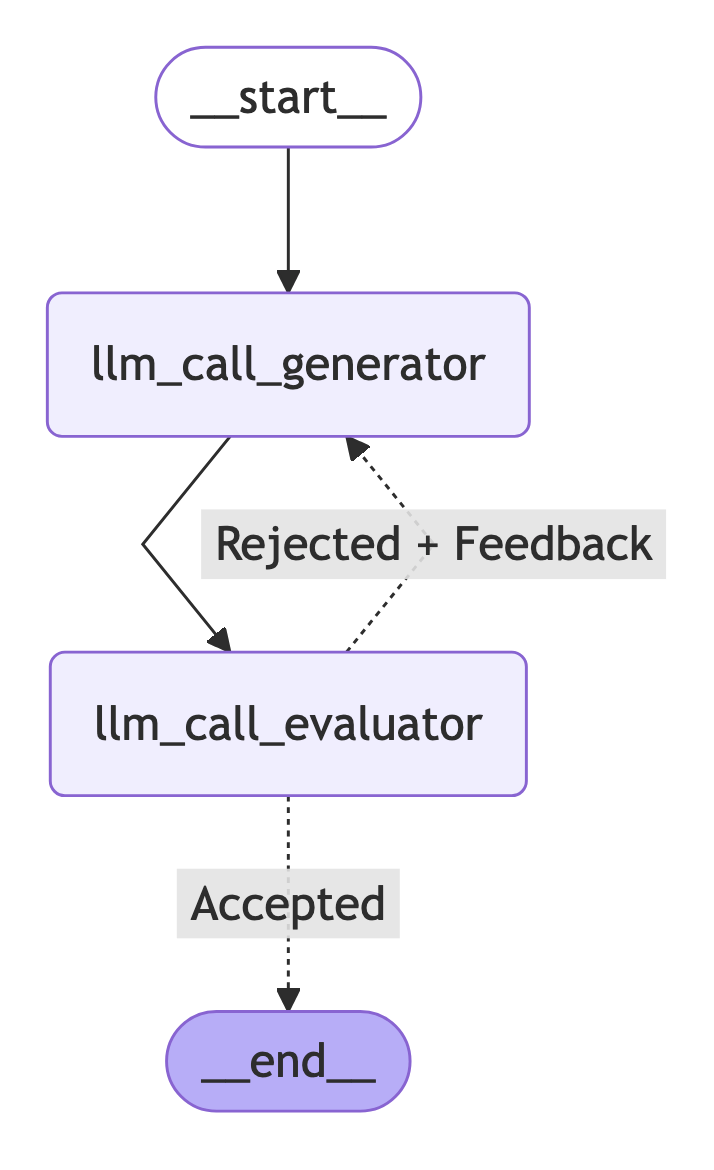

In [28]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))

In [29]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

Why did the cat join the Red Cross?

Because he wanted to be a first-aid kit! (First-aid cat)


### Resources: ###

### Examples ###

[Here](https://github.com/langchain-ai/local-deep-researcher) is an assistant that uses evaluator-optimizer to improve a report. See our video [here](https://www.youtube.com/watch?v=XGuTzHoqlj8).

[Here](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag_local/) is a RAG workflow that grades answers for hallucinations or errors. See our video [here](https://www.youtube.com/watch?v=bq1Plo2RhYI).

## Agent ##

에이전트는 일반적으로 루프 내에서 환경 피드백에 기반하여 도구 호출을 통해 작업을 수행하는 LLM으로 구현됩니다. Anthropic 블로그의 Building Effective Agents에서 언급했듯이:

에이전트는 복잡한 작업을 처리할 수 있지만, 구현은 간단한 경우가 많습니다. 일반적으로 루프 내에서 환경 피드백에 기반한 도구를 사용하는 LLM입니다. 따라서 도구 세트와 관련 문서를 명확하고 신중하게 설계하는 것이 중요합니다.

```에이전트 사용 시기```: 에이전트는 필요한 단계 수를 예측하기 어렵거나 불가능하고 고정된 경로를 하드코딩할 수 없는 개방형 문제에 사용할 수 있습니다. LLM은 여러 차례 작동할 가능성이 있으며, LLM의 의사 결정에 대한 어느 정도의 신뢰가 필요합니다. 에이전트의 자율성은 신뢰할 수 있는 환경에서 작업을 확장하는 데 이상적입니다.

![agent](agent.png)

API Reference: [tool](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.convert.tool.html)

In [3]:
from langchain_core.tools import tool

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int    
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int    
    """
    return a / b

# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = { tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [11]:

from langgraph.graph import MessagesState, StateGraph
from langgraph.graph import START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from typing_extensions import Literal
from IPython.display import Image

# Nodes
def llm_call(state: MessagesState):
    # Define the system message content
    # 'tools' is defined in the previous cell and accessible here.
    tool_names = [tool.name for tool in tools]
    system_prompt_content = (
        f"You are a helpful assistant. You are equipped with the following tools: {', '.join(tool_names)}. "
        "Use these tools when necessary to respond to the user's request. "
        "When you have a final answer, respond directly to the user without invoking a tool."
    )
    
    # Create the SystemMessage instance
    new_system_message = SystemMessage(content=system_prompt_content)
    
    current_messages = state['messages']
    
    # Filter out any existing SystemMessage(s) from the current messages
    # and prepend our new system message. This ensures that for this specific LLM call,
    # our intended system guidance is active and (typically) singular.
    messages_for_llm = [new_system_message] + [
        msg for msg in current_messages if not isinstance(msg, SystemMessage)
    ]
    
    # Invoke the LLM with the modified list of messages
    response = llm_with_tools.invoke(messages_for_llm)
    
    # Return the LLM's response to be added to the graph's state
    return {"messages": [response]}

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_contine(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whetehr the LLM amde a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END



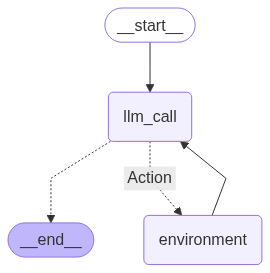

In [12]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_contine,
    {
        # Name retturned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [13]:
# Invoke 
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (1abab631-4a17-484e-ade0-2030cb41c314)
 Call ID: 1abab631-4a17-484e-ade0-2030cb41c314
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================

7
================================== Ai Message ==================================

7


### Resources: ###

#### LangChain Academy ####

See our lesson on agents [here](https://github.com/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb).

### Examples ###

[Here](https://github.com/langchain-ai/memory-agent) is a project that uses a tool calling agent to create / store long-term memories.

### Pre-built ###

LangGraph also provides a **pre-built** method for creating an agent as defined above (using the [```create_react_agent```](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_agent) function):

[How-tos/create-react-agent](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/)


API Reference: [create_react_agent](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent)

In [14]:
from langgraph.prebuilt import create_react_agent

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node
pre_built_agent = create_react_agent(llm, tools=tools)

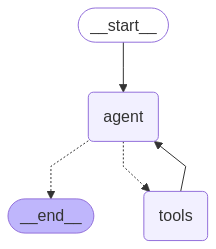

In [16]:
# Show the agent
display(Image(pre_built_agent.get_graph().draw_mermaid_png()))

In [17]:
# Invoke 
messages = [HumanMessage(content="Add 3 and 4")]
messages = pre_built_agent.invoke({"messages": messages})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4
================================== Ai Message ==================================
Tool Calls:
  add (00a1a50a-ceae-4074-960e-89f852e163c3)
 Call ID: 00a1a50a-ceae-4074-960e-89f852e163c3
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

Okay, the sum of 3 and 4 is 7.


### LangSmith Trace ###

https://smith.langchain.com/public/abab6a44-29f6-4b97-8164-af77413e494d/r



## What LangGraph provides ##
By constructing each of the above in LangGraph, we get a few things:

### Persistence: Human-in-the-Loop ###
LangGraph persistence layer supports interruption and approval of actions (e.g., Human In The Loop). See [Module 3 of LangChain Academy](https://github.com/langchain-ai/langchain-academy/tree/main/module-3).

### Persistence: Memory ###
LangGraph persistence layer supports conversational (short-term) memory and long-term memory. See [Modules 2](https://github.com/langchain-ai/langchain-academy/tree/main/module-2) [and 5](https://github.com/langchain-ai/langchain-academy/tree/main/module-5) of LangChain Academy:

### Streaming ###
LangGraph provides several ways to stream workflow / agent outputs or intermediate state. See [Module 3 of LangChain Academy](https://github.com/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb).

### Deployment ###
LangGraph provides an easy on-ramp for deployment, observability, and evaluation. See [Module 6 of LangChain Academy](https://github.com/langchain-ai/langchain-academy/tree/main/module-6).


